# Competitive Balance in the NHL

WORK-IN-PROGRESS

## Goal

+ Analyze how rule changes and/or lockouts have impacted competitive balance in the NHL

## Questions to Answer

+ What is competitive balance? How can it be measured?
+ What are key time periods in the NHL? Lockouts and/or major rule changes
+ How has competitive balanced changed across the major time periods? Is there any statistical significance to the findings?

## NHL Standings Data

We are querying the history of the NHL standings using a helper function that connects to the NHL stats API. There isn't a ton of documentation, but this [repo](https://github.com/dword4/nhlapi) is a great place to start for understanding what is available. 

First we use a function to query the games played (GP) and point percentage for each team in a single season , and then we iterate through each season in history using that function to collect all historical results. 

In [5]:
import requests
from tqdm import tqdm
import numpy as np
import pandas as pd


def fetch_season_summary(season: str):
    """
    Query team standings for a given season.
    """
    # dictionary holder for the season
    season_standings = dict()

    # api request
    base_url = 'https://statsapi.web.nhl.com/api/v1/standings/byLeague'
    season_id = f'?season={season}'
    season = requests.get(base_url + season_id)
    # throws an error for the missing lockout season
    try:
        season_records = season.json()['records'][0]

        # extract results
        season_standings['season'] = season_records['season']
        season_standings['num_teams'] = len(season_records['teamRecords'])
        results = [{
            'team': team['team']['name'],
            'gp': team['gamesPlayed'],
            'points': team['points'],
            'points_pct': team['pointsPercentage']
        } for team in season_records['teamRecords']
        ]
        season_standings['standings_df'] = pd.DataFrame(results)
        return season_standings
    except Exception:
        pass


def fetch_season_history(start_season='19171918', end_season='20202021'):
    """
    Query team standings for every season between start_season and end_season
    (inclusive)
    """
    # convert to ints for incrementing after each loop
    start_season_start = int(start_season[:4])
    start_season_end = int(start_season[-4:])
    end_season_start = int(end_season[:4])
    current_start = start_season_start
    current_end = start_season_end
    all_seasons = list()
    for _ in tqdm(np.arange(start_season_start, end_season_start + 1)):
        season = str(current_start) + str(current_end)
        season_dict = fetch_season_summary(season)
        if season_dict is not None:
            all_seasons.append(season_dict)
        current_start += 1
        current_end += 1
    return all_seasons

In [6]:
all_seasons = fetch_season_history('19171918', '20202021')

100%|██████████| 104/104 [00:09<00:00, 11.17it/s]


The innagural NHL season was in 1917-1918 with four teams. We can see the results below. 

In [35]:
# list of dict for each season
all_seasons[0]

{'season': '19171918',
 'num_teams': 4,
 'standings_df':                      team  gp  points  points_pct
 0      Montréal Canadiens  22      26    0.590909
 1          Toronto Arenas  22      26    0.590909
 2  Ottawa Senators (1917)  22      18    0.409091
 3      Montreal Wanderers   6       2    0.166667}

Despite our progress bar showing 104 seasons, we only have 103 for analysis as the 2004-2005 season was lost due to a lockout. 

In [8]:
print(f'Total seasons: {len(all_seasons)}')

Total seasons: 103


## Calculating Competitive Balance

There are two metrics we will use to analyze competitive balance:

1. Within-season variation (regular season)
2. HHI (championships)

In [41]:
def calculate_within_season_var(standings_df: pd.DataFrame):
    """
    Calculate competitive balance for the season. This assumes that the ideal
    point percentage is the average point percentage for the season, which may
    not be 0.5.
    """
    actual_std = standings_df.points_pct.std(ddof=0)
    # assumes perfect balance is every team at mean
    point_pct = standings_df.points.sum() / (standings_df.gp.sum() * 2)
    gp = standings_df.gp.mean()
    ideal_std = np.sqrt((point_pct * (1-point_pct))) / np.sqrt(gp)
    max_points = standings_df.points_pct.max()
    min_points = standings_df.points_pct.min()
    return {
        'gp': gp,
        'point_pct_avg': np.round(point_pct, 6),
        'actual_std': actual_std,
        'ideal_std': ideal_std,
        'ratio': actual_std / ideal_std
    }

For each iteration in the list comprehension, we extract the season label and then unpack the competitive balance dictionary result. The results for each season are stored as a pandas dataframe. 

In [45]:
competitive_balance_df = pd.DataFrame([
    {
        'season': season['season'],
        'num_teams': season['num_teams'],
        **calculate_within_season_var(season['standings_df'])
    }
    for season in all_seasons
])

We can see the first few seasons had very little teams and games played. 

In [46]:
competitive_balance_df.head()

,season,num_teams,gp,point_pct_avg,actual_std,ideal_std,ratio
0,19171918,4,18.0,0.5,0.174078,0.117851,1.477098
1,19181919,3,18.0,0.5,0.163551,0.117851,1.387777
2,19191920,4,24.0,0.5,0.222439,0.102062,2.179449
3,19201921,4,24.0,0.5,0.147314,0.102062,1.443376
4,19211922,4,24.0,0.5,0.125865,0.102062,1.233221


The most recent seasons were cut short due to COVID-19 and had a higher average points percentage due to points for overtime losses. 

In [48]:
competitive_balance_df.tail()

,season,num_teams,gp,point_pct_avg,actual_std,ideal_std,ratio
98,20162017,30,82.000000,0.558740,0.090735,0.054833,1.654746
99,20172018,31,82.000000,0.558222,0.092602,0.054840,1.688573
100,20182019,31,82.000000,0.553304,0.081895,0.054901,1.491679
101,20192020,31,69.806452,0.557763,0.084668,0.059444,1.424336
102,20202021,31,56.000000,0.556164,0.115598,0.066392,1.741138


## Define Season Groupings

In [47]:
# ideas
# original 6 era
# expansion
# dead puck era
# shooutout added
# 3v3 + shootout added

## Plot Ratio Over Time

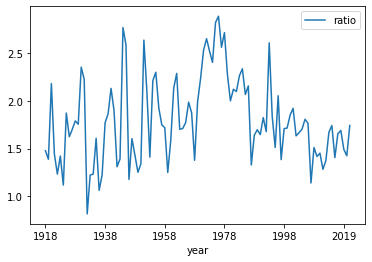

In [33]:
# replace with a plottly chart
competitive_balance_df['year'] = competitive_balance_df['season'].str[-4:]
competitive_balance_df.plot(x='year', y='ratio');